# <u> SOLVING HOMELESSNESS </u>




- in this project, we aim to solve the current shelter allocation problem for the city of Toronto. In particular We aim to solve this problem by

1. Predicting the amount of homeless people per region

2. Using LP's to optimize shelter allocation such that we:
    - Minimize distance travelled to each shelter
    - Respect each shetlers individual shelter constraints

3. After determiining optimal allocation subject to constraints, we will then do further analysis such as:
    - What are the binding constraints + what they mean 
    - What if analysis: optimal locaiton to  add additional shelter

In [1]:
# open virual environment 
# python -m venv venv
# .\venv\Scripts\Activate

# import the necessary packages

import pandas as pd 
import numpy as np 
import geopandas as gpd
from geopy.geocoders import Nominatim

from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Point



# Cleaning + Re-scoping

In [2]:
# the first dataset we will look at + clean will be the shelter_overnight dataset
# in particular we wll define the scope here as
# only in 2024
# only in the city of toronto
# only for the sectors MEN and WOMEN 

shelter_overnight_df = pd.read_csv(r"C:\Users\ahmed\IA2\Datasets\daily-shelter-overnight-service-occupancy-capacity-2024.csv", index_col=0)

for feature in shelter_overnight_df.columns:
    print(f"FEATURE: {feature}")
    print(shelter_overnight_df[feature].unique()[:3])





FEATURE: OCCUPANCY_DATE
['2024-01-01' '2024-01-02' '2024-01-03']
FEATURE: ORGANIZATION_ID
[24 14 23]
FEATURE: ORGANIZATION_NAME
['COSTI Immigrant Services' 'Christie Ossington Neighbourhood Centre'
 'Christie Refugee Welcome Centre, Inc.']
FEATURE: SHELTER_ID
[40 22 39]
FEATURE: SHELTER_GROUP
['COSTI Reception Centre' "Christie Ossington Men's Hostel"
 'Christie Refugee Welcome Centre']
FEATURE: LOCATION_ID
[1320. 1051. 1114.]
FEATURE: LOCATION_NAME
['COSTI Hotel Program Dixon' 'COSTI Reception Centre'
 'COSTI Uptown Hotel Program']
FEATURE: LOCATION_ADDRESS
['640 Dixon Rd.' '100 Lippincott St' '55 Hallcrown Pl']
FEATURE: LOCATION_POSTAL_CODE
['M9W 1J1' 'M5S 2P1' 'M2J 4R1']
FEATURE: LOCATION_CITY
['Toronto' 'North York' 'Etobicoke']
FEATURE: LOCATION_PROVINCE
['ON' nan]
FEATURE: PROGRAM_ID
[16892 16891 12251]
FEATURE: PROGRAM_NAME
['COSTI - Hotel Program - Dixon (Refugee Families)'
 'COSTI - Hotel Program - Dixon (Refugee Singles)'
 'COSTI Reception Centre CITY Program']
FEATURE: SECTO

In [3]:
# we need 
# LOCATION_CITY = 'Toronto'
# SECTOR = ['Men' 'Women']


filter_shelter = shelter_overnight_df.copy()

filter_shelter = filter_shelter[ (filter_shelter['LOCATION_CITY']=='Toronto') & (((filter_shelter['SECTOR']=='Men') | (filter_shelter['SECTOR']=='Women')))]

#for col in filter_shelter.columns:
    #print(col)

print(len(list(filter_shelter['PROGRAM_ID'])))
print(filter_shelter['PROGRAM_ID'].nunique())

unique_program_id = filter_shelter['PROGRAM_ID'].unique()

newy_shelter = filter_shelter.drop_duplicates(subset=['PROGRAM_ID'])

newy_shelter





18233
55


,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,...,OCCUPIED_BEDS,UNOCCUPIED_BEDS,UNAVAILABLE_BEDS,CAPACITY_ACTUAL_ROOM,CAPACITY_FUNDING_ROOM,OCCUPIED_ROOMS,UNOCCUPIED_ROOMS,UNAVAILABLE_ROOMS,OCCUPANCY_RATE_BEDS,OCCUPANCY_RATE_ROOMS
_id,,,,,,,,,,,,,,,,,,,,,
7,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1172.0,CONC West End Hotel Program,14 Roncesvalles Ave,M6R 2K3,Toronto,...,NaN,NaN,NaN,39.0,41.0,39.0,0.0,2.0,NaN,100.0
8,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1029.0,CONC Men's Shelter Lansdowne Ave,973 Lansdowne Ave,M6H 3Z5,Toronto,...,42.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN
9,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1102.0,CONC Men's Shelter Bloor St W,850 Bloor St W,M6G 1M2,Toronto,...,30.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN
14,2024-01-01,1,City of Toronto,60,Downsview Dells,1009.0,TSSS Downsview Dells,1651 Sheppard Ave W,M3M 2X4,Toronto,...,14.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,77.78,NaN
19,2024-01-01,1,City of Toronto,62,Fort York Residence,1011.0,TSSS Fort York Residence,38 Bathurst St,M5V 3W3,Toronto,...,61.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,89.71,NaN
20,2024-01-01,1,City of Toronto,62,Fort York Residence,1011.0,TSSS Fort York Residence,38 Bathurst St,M5V 3W3,Toronto,...,46.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,95.83,NaN
21,2024-01-01,1,City of Toronto,94,Progress Shelter,1360.0,Progress Avenue Shelter,705 Progress Ave,M1H 2X1,Toronto,...,101.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN
26,2024-01-01,1,City of Toronto,3,Seaton House,1154.0,TSSS Junction Place,731 Runnymede Rd,M6N 3V7,Toronto,...,62.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN
27,2024-01-01,1,City of Toronto,3,Seaton House,1008.0,TSSS Seaton House,339 George St,M5A 2N2,Toronto,...,66.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN


| **Feature**              | **Meaning / Description**                          | **Type**          | **Example Values**                                                    |
| ------------------------ | -------------------------------------------------- | ----------------- | --------------------------------------------------------------------- |
| `OCCUPANCY_DATE`         | Date of the overnight shelter record               | string / datetime | '2024-01-01', '2024-01-02', '2024-01-03'                              |
| `ORGANIZATION_ID`        | Unique ID for the organization running the shelter | int               | 24, 14, 23                                                            |
| `ORGANIZATION_NAME`      | Name of the organization                           | string            | 'COSTI Immigrant Services', 'Christie Ossington Neighbourhood Centre' |
| `SHELTER_ID`             | Unique ID for the shelter                          | int               | 40, 22, 39                                                            |
| `SHELTER_GROUP`          | Group / category of the shelter                    | string            | 'COSTI Reception Centre', "Christie Ossington Men's Hostel"           |
| `LOCATION_ID`            | Unique ID for the physical location                | float             | 1320, 1051, 1114                                                      |
| `LOCATION_NAME`          | Name of the shelter location                       | string            | 'COSTI Hotel Program Dixon', 'COSTI Reception Centre'                 |
| `LOCATION_ADDRESS`       | Street address of the shelter                      | string            | '640 Dixon Rd.', '100 Lippincott St'                                  |
| `LOCATION_POSTAL_CODE`   | Postal code                                        | string            | 'M9W 1J1', 'M5S 2P1'                                                  |
| `LOCATION_CITY`          | City or neighborhood                               | string            | 'Toronto', 'North York', 'Etobicoke'                                  |
| `LOCATION_PROVINCE`      | Province                                           | string            | 'ON', nan                                                             |
| `PROGRAM_ID`             | Unique ID for the shelter program                  | int               | 16892, 16891, 12251                                                   |
| `PROGRAM_NAME`           | Name of the program                                | string            | 'COSTI - Hotel Program - Dixon (Refugee Families)'                    |
| `SECTOR`                 | Target population for the program                  | string            | 'Families', 'Mixed Adult', 'Men'                                      |
| `PROGRAM_MODEL`          | Type of shelter program                            | string            | 'Emergency', 'Transitional'                                           |
| `OVERNIGHT_SERVICE_TYPE` | Type of service (shelter type)                     | string            | 'Motel/Hotel Shelter', 'Shelter', 'Warming Centre'                    |
| `PROGRAM_AREA`           | Broad program classification                       | string            | 'Temporary Refugee Response', 'Base Program - Refugee'                |
| `SERVICE_USER_COUNT`     | Number of clients served on that date              | int               | 650, 113, 8                                                           |
| `CAPACITY_TYPE`          | Capacity measured by beds or rooms                 | string            | 'Room Based Capacity', 'Bed Based Capacity'                           |
| `CAPACITY_ACTUAL_BED`    | Actual number of beds available                    | float             | nan, 8, 42                                                            |
| `CAPACITY_FUNDING_BED`   | Number of beds funded                              | float             | nan, 8, 42                                                            |
| `OCCUPIED_BEDS`          | Number of beds occupied                            | float             | nan, 8, 42                                                            |
| `UNOCCUPIED_BEDS`        | Number of beds unoccupied                          | float             | nan, 0, 4                                                             |
| `UNAVAILABLE_BEDS`       | Beds not available                                 | float             | nan, 0, 2                                                             |
| `CAPACITY_ACTUAL_ROOM`   | Actual number of rooms available                   | float             | 149, 57, nan                                                          |
| `CAPACITY_FUNDING_ROOM`  | Number of rooms funded                             | float             | 150, 57, nan                                                          |
| `OCCUPIED_ROOMS`         | Number of rooms occupied                           | float             | 149, 57, nan                                                          |
| `UNOCCUPIED_ROOMS`       | Rooms not occupied                                 | float             | 0, nan, 1                                                             |
| `UNAVAILABLE_ROOMS`      | Rooms not available                                | float             | 1, 0, nan                                                             |
| `OCCUPANCY_RATE_BEDS`    | Percent of beds occupied                           | float             | nan, 100, 82.61                                                       |
| `OCCUPANCY_RATE_ROOMS`   | Percent of rooms occupied                          | float             | 100, nan, 90                                                          |


# IMPORTANT FEATURES

1) SHELTER_ADDRESS: used to locate shelter in map 
2) SHELTER_ID: helps uiquly identify shltesf
3) LOCATION_CITY: 
4) SECTOR: find shlters for men, women, etc
5) SERVICE_COUNT: Number of people visiting an individual shelter per program, per shelter, per day  -> this helps us bun the bed or room contraints
6) 


In [4]:
# we will et total nmber of indivudual Men and Women Shelters

shelters_count = filter_shelter.groupby('SECTOR')['LOCATION_NAME'].nunique().reset_index()
shelters_count.rename(columns={'LOCATION_NAME':'num_shelters'}, inplace=True)

shelters_count


,SECTOR,num_shelters
0,Men,24
1,Women,18


In [5]:
filter_shelter[ (filter_shelter['SECTOR'] == 'Men') & (filter_shelter['SECTOR']=='Women')]

,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,...,OCCUPIED_BEDS,UNOCCUPIED_BEDS,UNAVAILABLE_BEDS,CAPACITY_ACTUAL_ROOM,CAPACITY_FUNDING_ROOM,OCCUPIED_ROOMS,UNOCCUPIED_ROOMS,UNAVAILABLE_ROOMS,OCCUPANCY_RATE_BEDS,OCCUPANCY_RATE_ROOMS
_id,,,,,,,,,,,,,,,,,,,,,


In [6]:
# Step 1: Filter Toronto shelters for Men or Women
toronto_shelters = shelter_overnight_df[
    (shelter_overnight_df['LOCATION_CITY'] == 'Toronto') &
    (shelter_overnight_df['SECTOR'].isin(['Men', 'Women']))
]

# Step 2: Group by shelter ID and collect all sectors per shelter
shelter_sectors = toronto_shelters.groupby('SHELTER_ID')['SECTOR'].unique().reset_index()

# Step 3: Classify shelters
def classify(sectors):
    if set(sectors) == {'Men'}:
        return 'Men only'
    elif set(sectors) == {'Women'}:
        return 'Women only'
    else:
        return 'Both'

shelter_sectors['type'] = shelter_sectors['SECTOR'].apply(classify)

# Step 4: Count shelters by type
counts = shelter_sectors['type'].value_counts()
print(counts)

all_shell = counts.sum()
print(f"the total number of shleters we are looking at is {all_shell}")

# FROM THIS we obsesve that some shtlers are double ocutned above in name, this is a result of certain shlering ofering multiple programs 
# therefore after going by shelter id, we find the true nubmer

type
Men only      14
Women only    13
Both           2
Name: count, dtype: int64
the total number of shleters we are looking at is 29


In [7]:

## ROOM BASED ANALYSYS: in here we uncover the number of people that can be alotted for room based shelters


# Step 1: Filter room-based shelters in Toronto for Men/Women
room_based = filter_shelter[filter_shelter['CAPACITY_TYPE'] == 'Room Based Capacity'].copy()

# Step 2: Compute max people and max rooms per shelter
shelter_stats = room_based.groupby([ 'LOCATION_CITY', 'SECTOR', 'SHELTER_ID', 'LOCATION_ADDRESS']).agg(max_people_served=('SERVICE_USER_COUNT', 'max'), max_rooms_occupied=('OCCUPIED_ROOMS', 'max')).reset_index()

# Step 3: Calculate average people per room per shelter (using max values)
shelter_stats['avg_people_per_room'] = shelter_stats['max_people_served'] / shelter_stats['max_rooms_occupied']


## additoinaly, as a snaity, I will check the number of bed vs 

# Step 4: Display
shelter_stats




,LOCATION_CITY,SECTOR,SHELTER_ID,LOCATION_ADDRESS,max_people_served,max_rooms_occupied,avg_people_per_room
0,Toronto,Men,16,335 Jarvis St,47,47.0,1.000000
1,Toronto,Men,22,14 Roncesvalles Ave,40,40.0,1.000000
2,Toronto,Men,30,556 Sherbourne St,31,31.0,1.000000
3,Toronto,Women,36,26 Gerrard St E,47,33.0,1.424242


In [8]:
# Step 1: Use filtered Toronto Men/Women shelters
# filter_shelter already has Toronto & SECTOR in ['Men','Women']

# Step 2: Group by shelter ID and get unique capacity types per shelter
shelter_capacity = filter_shelter.groupby('SHELTER_ID')['CAPACITY_TYPE'].unique().reset_index()

# Step 3: Count number of shelters by capacity type
def classify_capacity(cap_types):
    if len(cap_types) == 1:
        return cap_types[0]  # Bed Based or Room Based
    else:
        return 'Both'        # Shelter has programs with both capacity types

shelter_capacity['type'] = shelter_capacity['CAPACITY_TYPE'].apply(classify_capacity)

# Step 4: Count shelters per type
capacity_counts = shelter_capacity['type'].value_counts()
print(capacity_counts)


type
Bed Based Capacity     25
Both                    3
Room Based Capacity     1
Name: count, dtype: int64


from the above snippet we have determined a few important facts

1) A individual shelter, marked by a unique SHELTER_ID can be associated with multiple programs allowing it to serve multiple SECTORS as well as alternate between ROOM vs BED based measurments
2) We track the number of daily visistors using SERVICE_USER_COUNT, which falls into 2 cases
    - bed based: SERVICE_USER_COUNT == BED_BASED_OCCUPIED
    - room based: SERVICE_USER_COUNT != ROOM_BASED_OCCUPIED

however from shelter_stats, we observe that for all shelters EXCEPT 26 Gerrard St E	 Womens shelter, each person is assigned to one room


C:\Users\ahmed\AppData\Local\Temp\ipykernel_15728\1726316438.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shelter_sector_occupancy = toronto_mw.groupby(['SHELTER_ID','SECTOR']).apply(lambda x: x['occupancy_rate'].mean()).reset_index(name='occupancy_rate')


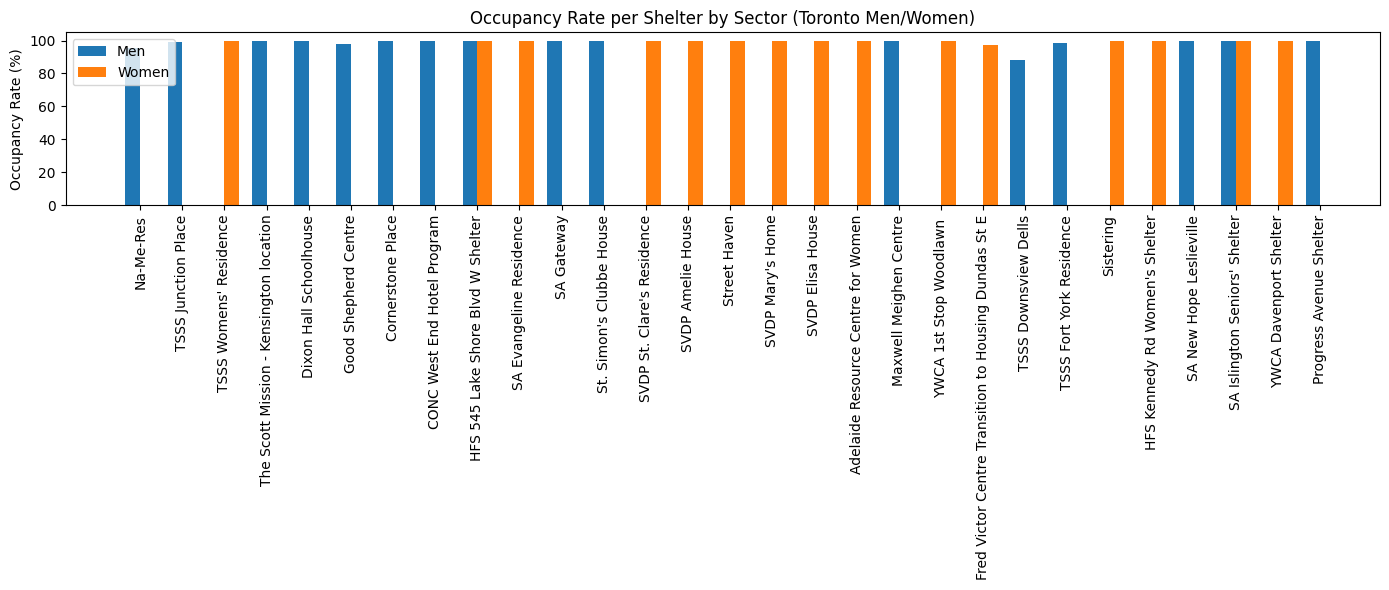

In [9]:
## PLOT THE OCCUPANCY RATE BED OR OCCPANCY RATE ROOMS FOR EACH


import matplotlib.pyplot as plt
import numpy as np

# Step 1: Filter Toronto Men/Women shelters (you already have filter_shelter)
toronto_mw = filter_shelter.copy()

# Step 2: Pick occupancy rate per row depending on capacity type
def get_occupancy(row):
    if row['CAPACITY_TYPE'] == 'Bed Based Capacity':
        return row['OCCUPANCY_RATE_BEDS']
    elif row['CAPACITY_TYPE'] == 'Room Based Capacity':
        return row['OCCUPANCY_RATE_ROOMS']
    else:  # Both
        return row['OCCUPANCY_RATE_BEDS'] if not np.isnan(row['OCCUPANCY_RATE_BEDS']) else row['OCCUPANCY_RATE_ROOMS']

toronto_mw['occupancy_rate'] = toronto_mw.apply(get_occupancy, axis=1)

# Step 3: Group by SHELTER_ID, SECTOR and get representative occupancy (mean or first)
shelter_sector_occupancy = toronto_mw.groupby(['SHELTER_ID','SECTOR']).apply(lambda x: x['occupancy_rate'].mean()).reset_index(name='occupancy_rate')

# Step 4: Plot side by side
shelters = shelter_sector_occupancy['SHELTER_ID'].unique()
x = np.arange(len(shelters))  
width = 0.35  # bar width

men_occ = shelter_sector_occupancy[shelter_sector_occupancy['SECTOR']=='Men'].set_index('SHELTER_ID').reindex(shelters)['occupancy_rate']
women_occ = shelter_sector_occupancy[shelter_sector_occupancy['SECTOR']=='Women'].set_index('SHELTER_ID').reindex(shelters)['occupancy_rate']

plt.figure(figsize=(14,6))
plt.bar(x - width/2, men_occ, width, label='Men')
plt.bar(x + width/2, women_occ, width, label='Women')
plt.xticks(x, [toronto_mw[toronto_mw['SHELTER_ID']==sid]['LOCATION_NAME'].iloc[0] for sid in shelters], rotation=90)
plt.ylabel("Occupancy Rate (%)")
plt.title("Occupancy Rate per Shelter by Sector (Toronto Men/Women)")
plt.legend()
plt.tight_layout()
plt.show()




In [10]:
men_df = pd.DataFrame(men_occ)
men_df.sort_values(ascending=True, by='occupancy_rate')




,occupancy_rate
SHELTER_ID,
60,87.981257
1,95.767090
16,97.713471
62,98.567049
3,98.838711
22,99.939912
45,99.948087
77,99.958497
94,99.959399


In [11]:
women_df = pd.DataFrame(women_occ)
women_df.sort_values(ascending=True, by='occupancy_rate')




,occupancy_rate
SHELTER_ID,
58,97.065505
42,99.556694
65,99.607240
78,99.882951
24,99.943005
50,99.946776
34,99.954426
77,99.955738
4,99.956230


In [12]:
# Step 1: Filter Toronto shelters for Men or Women
toronto_shelters = filter_shelter[
    (filter_shelter['LOCATION_CITY'] == 'Toronto') &
    (filter_shelter['SECTOR'].isin(['Men', 'Women']))
]

# Step 2: Group by shelter ID and collect all sectors per shelter
shelter_sectors = toronto_shelters.groupby('PROGRAM_ID')['SECTOR'].unique().reset_index()

# Step 3: Classify shelters
def classify(sectors):
    sectors_set = set(sectors)
    if sectors_set == {'Men'}:
        return 'Men only'
    elif sectors_set == {'Women'}:
        return 'Women only'
    else:
        return 'Both'

shelter_sectors['type'] = shelter_sectors['SECTOR'].apply(classify)

# Step 4: Inspect
shelter_sectors



,PROGRAM_ID,SECTOR,type
0,11794,[Men],Men only
1,11798,[Women],Women only
2,11812,[Men],Men only
3,11815,[Men],Men only
4,11831,[Men],Men only
5,11871,[Men],Men only
6,11891,[Men],Men only
7,11897,[Men],Men only
8,11898,[Men],Men only
9,11899,[Men],Men only


In [13]:
newy_shelter = newy_shelter[(newy_shelter['LOCATION_CITY']=='Toronto') & newy_shelter['SECTOR'].isin(['Men', 'Women'])].copy()

newy_shelter['full_address'] = newy_shelter['LOCATION_ADDRESS'] + ", " + \
                                  newy_shelter['LOCATION_CITY'] + ", " + \
                                  newy_shelter['LOCATION_PROVINCE']

geolocator = Nominatim(user_agent="toronto_shelters_app")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def safe_geocode(address):
    try:
        return geocode(address, timeout=10)
    except Exception as e:
        print(f"Failed to geocode {address}: {e}")
        return None

newy_shelter['location'] = newy_shelter['full_address'].apply(safe_geocode)


newy_shelter['latitude'] = newy_shelter['location'].apply(lambda loc: loc.latitude if loc else None)
newy_shelter['longitude'] = newy_shelter['location'].apply(lambda loc: loc.longitude if loc else None)

def classify(sectors):
    s = set(sectors)
    if s == {'Men'}:
        return 'Men only'
    elif s == {'Women'}:
        return 'Women only'
    else:
        return 'Both'
    
    
newy_shelter['type'] = newy_shelter['SECTOR'].apply(classify)



In [14]:
newy_shelter

,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,...,OCCUPIED_ROOMS,UNOCCUPIED_ROOMS,UNAVAILABLE_ROOMS,OCCUPANCY_RATE_BEDS,OCCUPANCY_RATE_ROOMS,full_address,location,latitude,longitude,type
_id,,,,,,,,,,,,,,,,,,,,,
7,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1172.0,CONC West End Hotel Program,14 Roncesvalles Ave,M6R 2K3,Toronto,...,39.0,0.0,2.0,NaN,100.0,"14 Roncesvalles Ave, Toronto, ON","(14, Roncesvalles Avenue, Roncesvalles, Sunnys...",43.639019,-79.446514,Both
8,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1029.0,CONC Men's Shelter Lansdowne Ave,973 Lansdowne Ave,M6H 3Z5,Toronto,...,NaN,NaN,NaN,100.00,NaN,"973 Lansdowne Ave, Toronto, ON","(973, Lansdowne Avenue, Wallace Emerson, Daven...",43.666098,-79.446011,Both
9,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1102.0,CONC Men's Shelter Bloor St W,850 Bloor St W,M6G 1M2,Toronto,...,NaN,NaN,NaN,100.00,NaN,"850 Bloor St W, Toronto, ON","(850, Bloor Street West, Dovercourt Village, U...",43.662443,-79.424144,Both
14,2024-01-01,1,City of Toronto,60,Downsview Dells,1009.0,TSSS Downsview Dells,1651 Sheppard Ave W,M3M 2X4,Toronto,...,NaN,NaN,NaN,77.78,NaN,"1651 Sheppard Ave W, Toronto, ON","(1651, Sheppard Avenue West, Downsview, York C...",43.742472,-79.496554,Both
19,2024-01-01,1,City of Toronto,62,Fort York Residence,1011.0,TSSS Fort York Residence,38 Bathurst St,M5V 3W3,Toronto,...,NaN,NaN,NaN,89.71,NaN,"38 Bathurst St, Toronto, ON","(38, Bathurst Street, Wellington Place, Spadin...",43.641817,-79.401972,Both
20,2024-01-01,1,City of Toronto,62,Fort York Residence,1011.0,TSSS Fort York Residence,38 Bathurst St,M5V 3W3,Toronto,...,NaN,NaN,NaN,95.83,NaN,"38 Bathurst St, Toronto, ON","(38, Bathurst Street, Wellington Place, Spadin...",43.641817,-79.401972,Both
21,2024-01-01,1,City of Toronto,94,Progress Shelter,1360.0,Progress Avenue Shelter,705 Progress Ave,M1H 2X1,Toronto,...,NaN,NaN,NaN,100.00,NaN,"705 Progress Ave, Toronto, ON","(705, Progress Avenue, Woburn North, Scarborou...",43.778314,-79.246465,Both
26,2024-01-01,1,City of Toronto,3,Seaton House,1154.0,TSSS Junction Place,731 Runnymede Rd,M6N 3V7,Toronto,...,NaN,NaN,NaN,100.00,NaN,"731 Runnymede Rd, Toronto, ON","(731, Runnymede Road, Junction Area, York Sout...",43.668090,-79.482960,Both
27,2024-01-01,1,City of Toronto,3,Seaton House,1008.0,TSSS Seaton House,339 George St,M5A 2N2,Toronto,...,NaN,NaN,NaN,100.00,NaN,"339 George St, Toronto, ON","(339, George Street, Moss Park, Toronto Centre...",43.659700,-79.374323,Both


In [15]:
# Filter Toronto shelters for Men or Women
toronto_shelters = filter_shelter[
    (filter_shelter['LOCATION_CITY'] == 'Toronto') & 
    (filter_shelter['SECTOR'].isin(['Men', 'Women']))
].copy()

# Step 1: Get unique shelters and combine sectors per shelter
unique_shelters = toronto_shelters.groupby('PROGRAM_ID').agg({
    'LOCATION_NAME': 'first',
    'SHELTER_ID': 'first',
    'LOCATION_ADDRESS': 'first',
    'LOCATION_CITY': 'first',
    'LOCATION_PROVINCE': 'first',
    'SECTOR': lambda x: list(set(x)),  # combine all unique sectors
    'CAPACITY_TYPE': 'first',
    'CAPACITY_ACTUAL_ROOM': 'first',
    'CAPACITY_ACTUAL_BED': 'first'
    
}).reset_index()

# Step 2: Create full address
unique_shelters['full_address'] = unique_shelters['LOCATION_ADDRESS'] + ", " + \
                                  unique_shelters['LOCATION_CITY'] + ", " + \
                                  unique_shelters['LOCATION_PROVINCE']

# Step 3: Initialize geolocator
geolocator = Nominatim(user_agent="toronto_shelters_app")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Step 4: Apply geocode safely
def safe_geocode(address):
    try:
        return geocode(address, timeout=10)
    except Exception as e:
        print(f"Failed to geocode {address}: {e}")
        return None

unique_shelters['location'] = unique_shelters['full_address'].apply(safe_geocode)

# Step 5: Extract latitude and longitude
unique_shelters['latitude'] = unique_shelters['location'].apply(lambda loc: loc.latitude if loc else None)
unique_shelters['longitude'] = unique_shelters['location'].apply(lambda loc: loc.longitude if loc else None)

# Step 6: Classify shelters by sector
def classify(sectors):
    s = set(sectors)
    if s == {'Men'}:
        return 'Men only'
    elif s == {'Women'}:
        return 'Women only'
    else:
        return 'Both'

unique_shelters['type'] = unique_shelters['SECTOR'].apply(classify)

# Step 7: Inspect the resulting DataFrame
unique_shelters




,PROGRAM_ID,LOCATION_NAME,SHELTER_ID,LOCATION_ADDRESS,LOCATION_CITY,LOCATION_PROVINCE,SECTOR,CAPACITY_TYPE,CAPACITY_ACTUAL_ROOM,CAPACITY_ACTUAL_BED,full_address,location,latitude,longitude,type
0,11794,Na-Me-Res,1,14 Vaughan Rd,Toronto,ON,[Men],Bed Based Capacity,NaN,54.0,"14 Vaughan Rd, Toronto, ON","(14, Vaughan Road, Wychwood, Toronto—St. Paul'...",43.681425,-79.418351,Men only
1,11798,TSSS Womens' Residence,4,674 Dundas St W,Toronto,ON,[Women],Bed Based Capacity,NaN,87.0,"674 Dundas St W, Toronto, ON","(674, Dundas Street West, Kensington Market, U...",43.651851,-79.403630,Women only
2,11812,TSSS Seaton House,3,339 George St,Toronto,ON,[Men],Bed Based Capacity,NaN,66.0,"339 George St, Toronto, ON","(339, George Street, Moss Park, Toronto Centre...",43.659700,-79.374323,Men only
3,11815,TSSS Downsview Dells,60,1651 Sheppard Ave W,Toronto,ON,[Men],Bed Based Capacity,NaN,18.0,"1651 Sheppard Ave W, Toronto, ON","(1651, Sheppard Avenue West, Downsview, York C...",43.742472,-79.496554,Men only
4,11831,TSSS Fort York Residence,62,38 Bathurst St,Toronto,ON,[Men],Bed Based Capacity,NaN,68.0,"38 Bathurst St, Toronto, ON","(38, Bathurst Street, Wellington Place, Spadin...",43.641817,-79.401972,Men only
5,11871,Sagatay,1,26 Vaughan Rd,Toronto,ON,[Men],Bed Based Capacity,NaN,17.0,"26 Vaughan Rd, Toronto, ON","(26, Vaughan Road, Wychwood, Toronto—St. Paul'...",43.681871,-79.418698,Men only
6,11891,The Scott Mission - Kensington location,8,346 Spadina Ave.,Toronto,ON,[Men],Bed Based Capacity,NaN,71.0,"346 Spadina Ave., Toronto, ON","(346, Spadina Avenue, Kensington Market, Unive...",43.654250,-79.398877,Men only
7,11897,Dixon Hall Schoolhouse,14,349 George St,Toronto,ON,[Men],Bed Based Capacity,NaN,30.0,"349 George St, Toronto, ON","(349, George Street, Moss Park, Toronto Centre...",43.660052,-79.374465,Men only
8,11898,Good Shepherd Centre Barrett House,16,35 Sydenham St,Toronto,ON,[Men],Bed Based Capacity,NaN,5.0,"35 Sydenham St, Toronto, ON","(35, Sydenham Street, Regent Park, Toronto Cen...",43.656743,-79.362350,Men only
9,11899,Good Shepherd Centre,16,412 Queen St E,Toronto,ON,[Men],Bed Based Capacity,NaN,25.0,"412 Queen St E, Toronto, ON","(412, Queen Street East, Regent Park, Toronto ...",43.656175,-79.362479,Men only


In [16]:
#unique_shelters.to_csv("SheltersByProgramName.csv", index=False)

unique_shelters[['PROGRAM_ID', 'LOCATION_NAME', 'CAPACITY_TYPE', 'CAPACITY_ACTUAL_ROOM', 'CAPACITY_ACTUAL_BED']]


capacities = unique_shelters[['PROGRAM_ID', 'LOCATION_NAME', 'CAPACITY_TYPE', 'CAPACITY_ACTUAL_ROOM', 'CAPACITY_ACTUAL_BED']].copy()

capacities.to_csv('ByProgramNameCapacities.csv')

In [17]:
newy_shelter.to_csv('unique_programname_coords.csv', index=False)

In [18]:
import folium

# Center the map roughly around Toronto
map_toronto = folium.Map(location=[43.7, -79.4], zoom_start=11)

# Define colors for each type
colors = {
    'Men only': 'blue',
    'Women only': 'red',
    'Both': 'purple'
}

# Add each shelter as a CircleMarker with popup
for idx, row in unique_shelters.iterrows():
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=7,
            color=colors[row['type']],
            fill=True,
            fill_color=colors[row['type']],
            fill_opacity=0.7,
            popup=folium.Popup(
                html=(
                    f"<b>{row['LOCATION_NAME']}</b><br>"
                    f"Type: {row['type']}<br>"
                    f"Address: {row['LOCATION_ADDRESS']}<br>"
                    f"Capacity type: {', '.join(row['CAPACITY_TYPE']) if isinstance(row['CAPACITY_TYPE'], list) else row['CAPACITY_TYPE']}"
                ),
                max_width=300
            )
        ).add_to(map_toronto)

# Optional: Add a legend
legend_html = """
 <div style="position: fixed; 
             bottom: 50px; left: 50px; width: 150px; height: 110px; 
             border:2px solid grey; z-index:9999; font-size:14px;
             background-color:white; padding: 10px;">
 <b>Shelter Type</b><br>
 <i class="fa fa-circle" style="color:blue"></i> Men only<br>
 <i class="fa fa-circle" style="color:red"></i> Women only<br>
 <i class="fa fa-circle" style="color:purple"></i> Both
 </div>
"""
map_toronto.get_root().html.add_child(folium.Element(legend_html))

# Display map
#map_toronto
map_toronto.save("toronto_map.html")


## We will now be dropping all the ppor people neighbourhooods!


1) We will be lookng at the neigbourhood profiles dataset and looking for the releavnt rows to get COUNTS
2) using these coutns we will INSHALLAH create a heatmap and the centroids



In [19]:
fwd_info_df = pd.read_csv(r'C:\Users\ahmed\IA2\Datasets\98-401-X2021013_eng_CSV_FWD\98-401-X2021013_English_CSV_data.csv', encoding="latin1")

fwd_info_df.head()


for uniq_char in fwd_info_df['CHARACTERISTIC_NAME'].unique():
    print(uniq_char)

Population, 2021
Population, 2016
Population percentage change, 2016 to 2021
Total private dwellings
Private dwellings occupied by usual residents
Population density per square kilometre
Land area in square kilometres
Total - Age groups of the population - 100% data
  0 to 14 years
    0 to 4 years
    5 to 9 years
    10 to 14 years
  15 to 64 years
    15 to 19 years
    20 to 24 years
    25 to 29 years
    30 to 34 years
    35 to 39 years
    40 to 44 years
    45 to 49 years
    50 to 54 years
    55 to 59 years
    60 to 64 years
  65 years and over
    65 to 69 years
    70 to 74 years
    75 to 79 years
    80 to 84 years
    85 years and over
      85 to 89 years
      90 to 94 years
      95 to 99 years
      100 years and over
Total - Distribution (%) of the population by broad age groups - 100% data
Average age of the population
Median age of the population
Total - Occupied private dwellings by structural type of dwelling - 100% data
  Single-detached house
  Semi-detached

In [20]:
fwd_info_df

,CENSUS_YEAR,DGUID,ALT_GEO_CODE,GEO_LEVEL,GEO_NAME,TNR_SF,TNR_LF,DATA_QUALITY_FLAG,CHARACTERISTIC_ID,CHARACTERISTIC_NAME,...,C2_COUNT_MEN+,SYMBOL.1,C3_COUNT_WOMEN+,SYMBOL.2,C10_RATE_TOTAL,SYMBOL.3,C11_RATE_MEN+,SYMBOL.4,C12_RATE_WOMEN+,SYMBOL.5
0,2021,2021A0011A0A,A0A,Forward sortation area,A0A,3.3,4.2,0,1,"Population, 2021",...,NaN,...,NaN,...,NaN,...,NaN,...,NaN,...
1,2021,2021A0011A0A,A0A,Forward sortation area,A0A,3.3,4.2,0,2,"Population, 2016",...,NaN,...,NaN,...,NaN,...,NaN,...,NaN,...
2,2021,2021A0011A0A,A0A,Forward sortation area,A0A,3.3,4.2,0,3,"Population percentage change, 2016 to 2021",...,NaN,...,NaN,...,NaN,...,NaN,...,NaN,...
3,2021,2021A0011A0A,A0A,Forward sortation area,A0A,3.3,4.2,0,4,Total private dwellings,...,NaN,...,NaN,...,NaN,...,NaN,...,NaN,...
4,2021,2021A0011A0A,A0A,Forward sortation area,A0A,3.3,4.2,0,5,Private dwellings occupied by usual residents,...,NaN,...,NaN,...,NaN,...,NaN,...,NaN,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4330621,2021,2021A0011Y1A,Y1A,Forward sortation area,Y1A,2.8,7.0,0,2627,Total - Eligibility and instruction in the min...,...,2450.0,NaN,2185.0,NaN,100.0,NaN,100.0,NaN,100.0,NaN
4330622,2021,2021A0011Y1A,Y1A,Forward sortation area,Y1A,2.8,7.0,0,2628,Children eligible for instruction in the min...,...,370.0,NaN,320.0,NaN,14.9,NaN,15.1,NaN,14.6,NaN
4330623,2021,2021A0011Y1A,Y1A,Forward sortation area,Y1A,2.8,7.0,0,2629,Eligible children who have been instructed...,...,270.0,NaN,250.0,NaN,11.3,NaN,11.0,NaN,11.4,NaN
4330624,2021,2021A0011Y1A,Y1A,Forward sortation area,Y1A,2.8,7.0,0,2630,Eligible children who have not been instru...,...,100.0,NaN,65.0,NaN,3.6,NaN,4.1,NaN,3.0,NaN


In [21]:

"""
mans looked at the dataset and picked 3 features, most of them have to do with meidan income but we chose LIM -> low income
^ important to note htt we get COUNTS for numbeer of people in each FWD stsafying charactersitc/feature 
"""


low_income_features = [
    "In low income based on the Low-income measure, after tax (LIM-AT)",
    "Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)",
    "Median after-tax income in 2020 among recipients ($)"]



low_income_df = fwd_info_df[fwd_info_df['CHARACTERISTIC_NAME'].isin(low_income_features)].copy()

low_income_df = low_income_df.reset_index(drop=True)



In [22]:
# Filter FSAs in Toronto (first letter "M")
toronto_fsa_df = low_income_df[low_income_df['GEO_NAME'].str.startswith("M")].copy()
toronto_fsa_df = toronto_fsa_df.reset_index(drop=True)



toronto_fsa_pivot = toronto_fsa_df.pivot_table(
    index='GEO_NAME',
    columns='CHARACTERISTIC_NAME',
    values='C1_COUNT_TOTAL'     
).reset_index()





from geopy.geocoders import Nominatim


geolocator = Nominatim(user_agent="toronto_fsa_geocoder")

def get_fsa_latlon(fsa_code):
    try:
        location = geolocator.geocode(f"Forward Sortation Area {fsa_code}, Toronto, Ontario, Canada")

        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            return pd.Series([None, None])
    except:
        return pd.Series([None, None])


toronto_fsa_pivot




CHARACTERISTIC_NAME,GEO_NAME,"In low income based on the Low-income measure, after tax (LIM-AT)","Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)"
0,M1B,6255.0,9.6
1,M1C,1910.0,5.4
2,M1E,6215.0,13.1
3,M1G,5390.0,17.5
4,M1H,3085.0,13.0
...,...,...,...
91,M9N,4175.0,16.2
92,M9P,2230.0,11.0
93,M9R,4150.0,12.3
94,M9V,6995.0,13.1


In [23]:
import geopandas as gpd

# Make sure to use a raw string (r"") or double backslashes \\ for Windows paths
shapefile_path = r"C:\Users\ahmed\IA2\lfsa000a16a_e\lfsa000a16a_e.shp"

# Load shapefile into a GeoDataFrame
geoframe = gpd.read_file(shapefile_path)

tfsa = geoframe[geoframe['CFSAUID'].str.startswith('M')].copy()

# Check first few rows
tfsa

,CFSAUID,PRUID,PRNAME,geometry
637,M9R,35,Ontario,"POLYGON ((7209908.14 928259.897, 7209816.766 9..."
638,M9V,35,Ontario,"POLYGON ((7206682.694 937743.451, 7206631.563 ..."
639,M9W,35,Ontario,"POLYGON ((7210531.76 934710.503, 7210542.117 9..."
701,M1P,35,Ontario,"POLYGON ((7233594.731 942118.174, 7233584.157 ..."
702,M1R,35,Ontario,"MULTIPOLYGON (((7231166.76 939882.914, 7231356..."
...,...,...,...,...
1226,M6M,35,Ontario,"POLYGON ((7216847.5 932886, 7216992.186 932544..."
1227,M6N,35,Ontario,"POLYGON ((7215682 930856.563, 7215994.5 930725..."
1228,M6P,35,Ontario,"POLYGON ((7219671.957 928249.763, 7219688.191 ..."
1244,M5P,35,Ontario,"POLYGON ((7222813.203 933279.526, 7222831.411 ..."


In [24]:
tfsa = tfsa.to_crs("EPSG:4326")
tfsa['Latitude'] = tfsa.geometry.centroid.y
tfsa['Longitude'] = tfsa.geometry.centroid.x
tfsa['centroid'] = tfsa.geometry.centroid

tfsa_coords = tfsa[['CFSAUID', 'Latitude', 'Longitude']].copy()

toronto_fsa_final = toronto_fsa_pivot.merge(
    tfsa_coords,
    left_on='GEO_NAME',
    right_on='CFSAUID',
    how='left'
)

toronto_fsa_final



C:\Users\ahmed\AppData\Local\Temp\ipykernel_15728\1884795667.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tfsa['Latitude'] = tfsa.geometry.centroid.y
C:\Users\ahmed\AppData\Local\Temp\ipykernel_15728\1884795667.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tfsa['Longitude'] = tfsa.geometry.centroid.x
C:\Users\ahmed\AppData\Local\Temp\ipykernel_15728\1884795667.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tfsa['centroid'] = tfsa.geometry.centroid


,GEO_NAME,"In low income based on the Low-income measure, after tax (LIM-AT)","Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)",CFSAUID,Latitude,Longitude
0,M1B,6255.0,9.6,M1B,43.818617,-79.191697
1,M1C,1910.0,5.4,M1C,43.787541,-79.155066
2,M1E,6215.0,13.1,M1E,43.766409,-79.185342
3,M1G,5390.0,17.5,M1G,43.772459,-79.216700
4,M1H,3085.0,13.0,M1H,43.766060,-79.238703
...,...,...,...,...,...,...
91,M9N,4175.0,16.2,M9N,43.706855,-79.518099
92,M9P,2230.0,11.0,M9P,43.694740,-79.532255
93,M9R,4150.0,12.3,M9R,43.687775,-79.557988
94,M9V,6995.0,13.1,M9V,43.742736,-79.594331


In [25]:


# since we have one percentage ans one COUNT, we will use min max scaling to across features then gets weghted scores

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

toronto_fsa_pivot[['low_income_count_scaled', 'low_income_pct_scaled']] = scaler.fit_transform(toronto_fsa_pivot[['In low income based on the Low-income measure, after tax (LIM-AT)', 'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)']])

toronto_fsa_pivot['low_income_score'] = (0.5 * toronto_fsa_pivot['low_income_count_scaled'] + 0.5 * toronto_fsa_pivot['low_income_pct_scaled'])



toronto_fsa_final = toronto_fsa_pivot.merge(
    tfsa_coords,
    left_on='GEO_NAME',
    right_on='CFSAUID',
    how='left'
)



weighted_fwd = toronto_fsa_final[['GEO_NAME', 'low_income_score']].copy()



In [26]:
tfsa.head(2)

,CFSAUID,PRUID,PRNAME,geometry,Latitude,Longitude,centroid
637,M9R,35,Ontario,"POLYGON ((-79.56131 43.67478, -79.56249 43.674...",43.687775,-79.557988,POINT (-79.55799 43.68778)
638,M9V,35,Ontario,"POLYGON ((-79.57759 43.76205, -79.57829 43.761...",43.742736,-79.594331,POINT (-79.59433 43.74274)


In [27]:
weighted_fwd.head(2)

,GEO_NAME,low_income_score
0,M1B,0.314583
1,M1C,0.053891


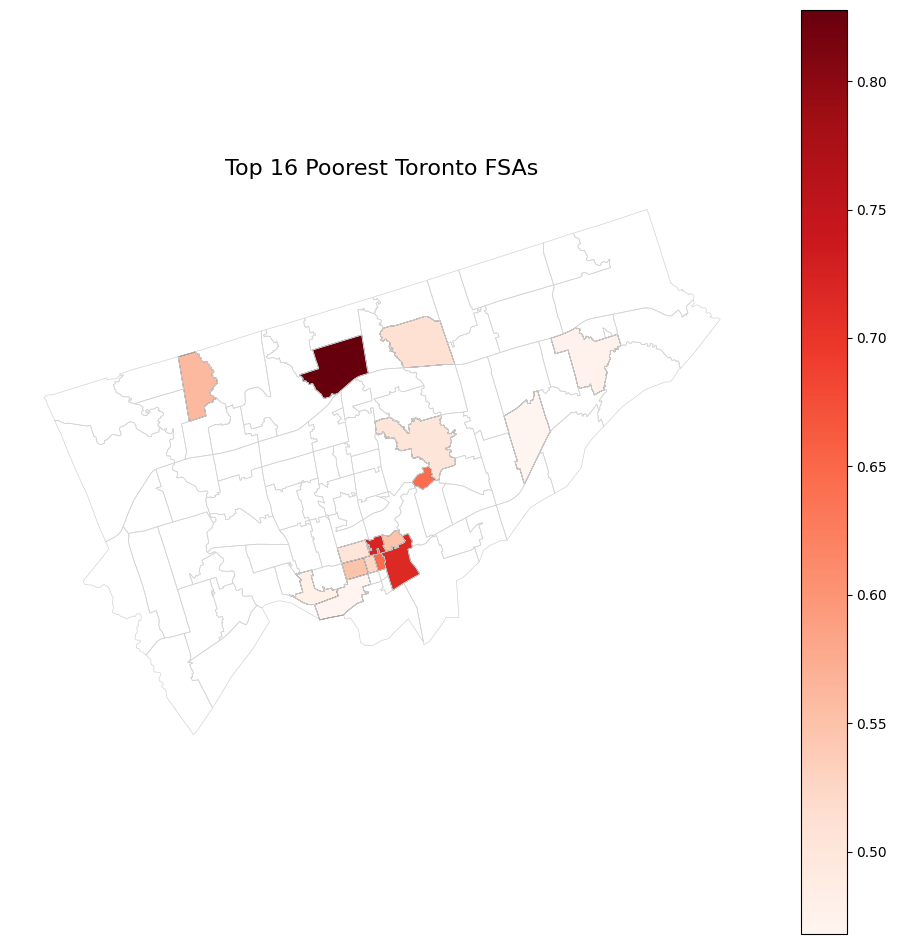

(16, 8)


,CFSAUID,PRUID,PRNAME,geometry,Latitude,Longitude,centroid,low_income_score
5,M2N,35,Ontario,"POLYGON ((-79.40328 43.75684, -79.40434 43.756...",43.767318,-79.410939,POINT (-79.41094 43.76732),0.827670
69,M4Y,35,Ontario,"POLYGON ((-79.37497 43.6678, -79.37467 43.6670...",43.666578,-79.381093,POINT (-79.38109 43.66658),0.723391
75,M5A,35,Ontario,"POLYGON ((-79.35583 43.66323, -79.35579 43.662...",43.656277,-79.362270,POINT (-79.36227 43.65628),0.716628
76,M5B,35,Ontario,"POLYGON ((-79.37807 43.66233, -79.378 43.66213...",43.657921,-79.377941,POINT (-79.37794 43.65792),0.645232
18,M4H,35,Ontario,"POLYGON ((-79.33792 43.70523, -79.33768 43.705...",43.704100,-79.343631,POINT (-79.34363 43.7041),0.643874
47,M3N,35,Ontario,"POLYGON ((-79.52046 43.77446, -79.52038 43.774...",43.757135,-79.520385,POINT (-79.52039 43.75713),0.560171
56,M5T,35,Ontario,"POLYGON ((-79.38966 43.6575, -79.38916 43.6563...",43.653528,-79.397317,POINT (-79.39732 43.65353),0.549059
65,M4X,35,Ontario,"POLYGON ((-79.35938 43.67017, -79.35927 43.670...",43.669234,-79.367960,POINT (-79.36796 43.66923),0.548928
79,M5G,35,Ontario,"POLYGON ((-79.38627 43.65092, -79.38661 43.650...",43.656109,-79.384952,POINT (-79.38495 43.65611),0.523485
35,M2J,35,Ontario,"POLYGON ((-79.33523 43.7928, -79.33501 43.7927...",43.780313,-79.347631,POINT (-79.34763 43.78031),0.512407


In [28]:
# Make sure weighted_fwd columns are flat
weighted_fwd.columns = ['CFSAUID', 'low_income_score']

# Ensure CFSAUIDs are strings
weighted_fwd['CFSAUID'] = weighted_fwd['CFSAUID'].astype(str).str.strip().str.upper()
tfsa['CFSAUID'] = tfsa['CFSAUID'].astype(str).str.strip().str.upper()


import matplotlib.pyplot as plt

def plot_top_k_poor_fsas(tfsa, weighted_fwd, k=10, cmap='Reds'):

    
    toronto_fsa_geo = tfsa.merge(weighted_fwd, on='CFSAUID', how='left')

    top_k = toronto_fsa_geo.sort_values(by='low_income_score', ascending=False).iloc[0:k]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    tfsa.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black', color='lightgray')
    
    top_k.plot(
        column='low_income_score',
        cmap=cmap,
        linewidth=0.5,
        edgecolor='black',
        legend=True,
        ax=ax
    )
    
    ax.set_title(f'Top {k} Poorest Toronto FSAs', fontsize=16)
    ax.axis('off')
    plt.show()
    
    return top_k

top_k_geo = plot_top_k_poor_fsas(tfsa, weighted_fwd, k=16)
print(top_k_geo.shape)
top_k_geo





## WE HAVE SUCCESULLT LOCATIED THE BROKE BOYS

now i wil attempt the impossible and plot the shtelrs locaiton and hosptos against eachother
PRAY

In [29]:





def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute the Haversine distance between two points in km.
    """
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

def distance_matrix(type_shelter, top_k_geo):
    """
    Compute distances in km from each shelter to each FSA centroid.
    
    Parameters:
        type_shelter: pd.DataFrame with columns 'latitude' and 'longitude'
        top_k_geo: pd.DataFrame with columns 'CFSAUID', 'Latitude', 'Longitude'

    Returns:
        pd.DataFrame: distance matrix, shelters as rows, FSAs as columns
    """
    shelter_coords = type_shelter[['latitude', 'longitude']].to_numpy()
    fsa_coords = top_k_geo[['Latitude', 'Longitude']].to_numpy()
    
    dist_matrix = np.zeros((shelter_coords.shape[0], fsa_coords.shape[0]))
    
    for i, (s_lat, s_lon) in enumerate(shelter_coords):
        for j, (f_lat, f_lon) in enumerate(fsa_coords):
            dist_matrix[i, j] = haversine_distance(s_lat, s_lon, f_lat, f_lon)
    
    dist_df = pd.DataFrame(
        dist_matrix,
        index=type_shelter['LOCATION_NAME'],
        columns=top_k_geo['CFSAUID']
    )
    
    return dist_df


#mens_shelters = unique_shelters[unique_shelters['SECTOR'].apply(lambda x: 'Men' in x)]
#women_shelters = unique_shelters[unique_shelters['SECTOR'].apply(lambda x: 'Women' in x)]
#mens_dist = distance_matrix(mens_shelters, top_k_geo)
#women_dist = distance_matrix(women_shelters, top_k_geo)
#anyone_dist = distance_matrix(unique_shelters, top_k_geo)


pr0gram_name_dist = distance_matrix(unique_shelters, top_k_geo)



In [56]:
by_address = pr0gram_name_dist.copy()

by_address.index = unique_shelters['LOCATION_ADDRESS']

by_address.to_csv('by_address_distance_matrix.csv')

In [31]:
pr0gram_name_dist.to_csv('distance_amtrix.csv')

In [32]:
top_k_geo.head(2)

,CFSAUID,PRUID,PRNAME,geometry,Latitude,Longitude,centroid,low_income_score
5,M2N,35,Ontario,"POLYGON ((-79.40328 43.75684, -79.40434 43.756...",43.767318,-79.410939,POINT (-79.41094 43.76732),0.827670
69,M4Y,35,Ontario,"POLYGON ((-79.37497 43.6678, -79.37467 43.6670...",43.666578,-79.381093,POINT (-79.38109 43.66658),0.723391


In [33]:
unique_shelters.head(2)

,PROGRAM_ID,LOCATION_NAME,SHELTER_ID,LOCATION_ADDRESS,LOCATION_CITY,LOCATION_PROVINCE,SECTOR,CAPACITY_TYPE,CAPACITY_ACTUAL_ROOM,CAPACITY_ACTUAL_BED,full_address,location,latitude,longitude,type
0,11794,Na-Me-Res,1,14 Vaughan Rd,Toronto,ON,[Men],Bed Based Capacity,NaN,54.0,"14 Vaughan Rd, Toronto, ON","(14, Vaughan Road, Wychwood, Toronto—St. Paul'...",43.681425,-79.418351,Men only
1,11798,TSSS Womens' Residence,4,674 Dundas St W,Toronto,ON,[Women],Bed Based Capacity,NaN,87.0,"674 Dundas St W, Toronto, ON","(674, Dundas Street West, Kensington Market, U...",43.651851,-79.403630,Women only


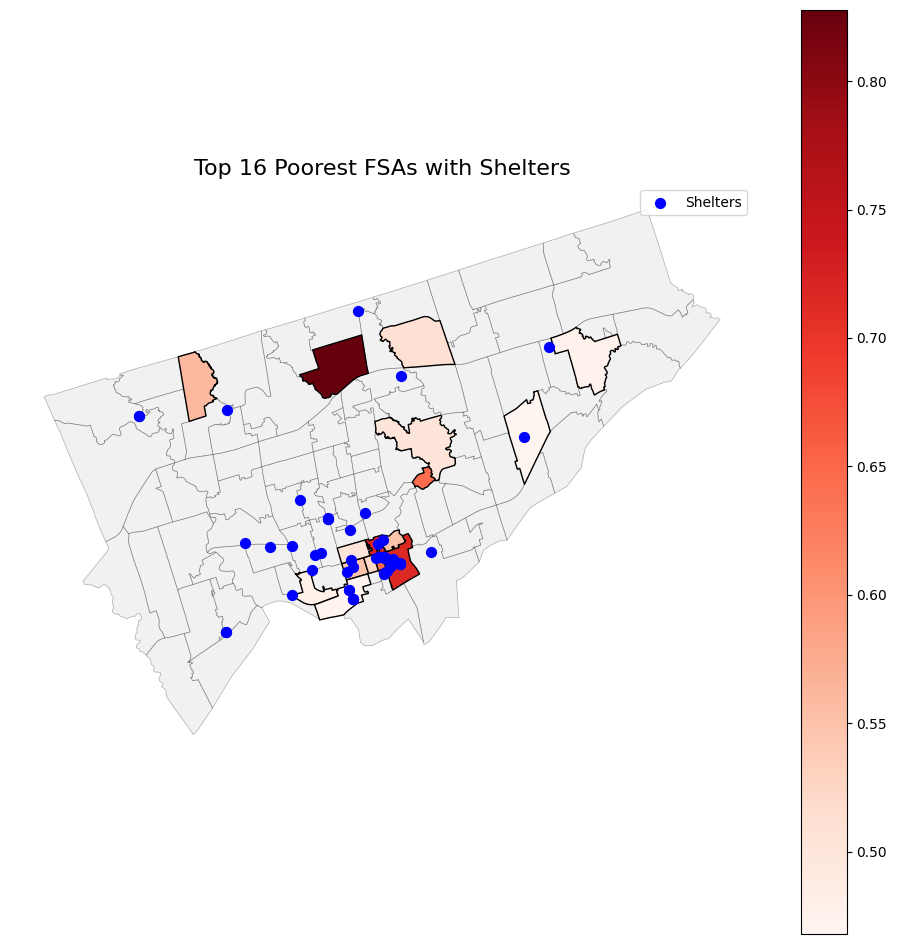

In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_fsas_and_shelters(top_k_geo, shelters, tfsa, 
                           score_column='low_income_score', 
                           title='Poorest FSAs with Shelters'):

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # Convert shelters to GeoDataFrame
    shelters_gdf = gpd.GeoDataFrame(
        shelters,
        geometry=gpd.points_from_xy(shelters['longitude'], shelters['latitude']),
        crs="EPSG:4326"
    ).to_crs(top_k_geo.crs)

    # --------------------------------------------------------
    # 1. Plot ALL FSAs (background layer)
    # --------------------------------------------------------
    tfsa.plot(
        ax=ax,
        linewidth=0.5,
        edgecolor='black',
        facecolor='lightgray',   # grey background
        alpha=0.3                # soft layer
    )

    # --------------------------------------------------------
    # 2. Plot the top_k FSAs (highlighted)
    # --------------------------------------------------------
    top_k_geo.plot(
        column=score_column,
        cmap='Reds',
        linewidth=1,
        edgecolor='black',
        legend=True,
        ax=ax
    )
    
    # --------------------------------------------------------
    # 3. Plot shelter locations
    # --------------------------------------------------------
    ax.scatter(
        shelters_gdf.geometry.x,
        shelters_gdf.geometry.y,
        s=50,
        marker='o',
        color='blue',
        label='Shelters'
    )
    
    ax.set_title(f'Top {len(top_k_geo)} {title}', fontsize=16)
    ax.axis('off')
    ax.legend()
    plt.show()


plot_fsas_and_shelters(top_k_geo, unique_shelters, tfsa, 
                       title='Poorest FSAs with Shelters')


Imma run monte carlo now


In [48]:
#from top_k_geo.shape we see 16 hotspots

"""
man_percent = 0.5
women_percent = 1-man_percent

for hotspot in range(top_k_geo.shape[0]):
"""

top_16_hotspots = top_k_geo.copy()

top_16_hotspots['low_income_score'] = top_16_hotspots['low_income_score'] / top_16_hotspots['low_income_score'].sum()


top_16_hotspots.head(2)



    

,CFSAUID,PRUID,PRNAME,geometry,Latitude,Longitude,centroid,low_income_score
5,M2N,35,Ontario,"POLYGON ((-79.40328 43.75684, -79.40434 43.756...",43.767318,-79.410939,POINT (-79.41094 43.76732),0.090482
69,M4Y,35,Ontario,"POLYGON ((-79.37497 43.6678, -79.37467 43.6670...",43.666578,-79.381093,POINT (-79.38109 43.66658),0.079082


In [49]:
unique_shelters.head(2)

,PROGRAM_ID,LOCATION_NAME,SHELTER_ID,LOCATION_ADDRESS,LOCATION_CITY,LOCATION_PROVINCE,SECTOR,CAPACITY_TYPE,CAPACITY_ACTUAL_ROOM,CAPACITY_ACTUAL_BED,full_address,location,latitude,longitude,type
0,11794,Na-Me-Res,1,14 Vaughan Rd,Toronto,ON,[Men],Bed Based Capacity,NaN,54.0,"14 Vaughan Rd, Toronto, ON","(14, Vaughan Road, Wychwood, Toronto—St. Paul'...",43.681425,-79.418351,Men only
1,11798,TSSS Womens' Residence,4,674 Dundas St W,Toronto,ON,[Women],Bed Based Capacity,NaN,87.0,"674 Dundas St W, Toronto, ON","(674, Dundas Street West, Kensington Market, U...",43.651851,-79.403630,Women only


In [51]:

#from unique_shelters.shape  we know there are 55 different shelters (Men and Women)

"""

while hotspots not empty

each hotspots has a number of men and women in group

we will simulate the starting at a hotspot h from H  

pick random from the group and assign to eligible shelter (row in dec matrix -> fimnd appropirate masking) 

if shelter_1 capcity not full:
update shhlter_1 
remove person from group

othetwise:
pick again 

"""

total_num_ppl = 1000
men_pct = 0.5 
women_pct = 1 - men_pct


# matrix with each row is [num men in hotpot, num women in hotpsot]
ppl_per_hotspot = []

for hotspot in range(top_16_hotspots.shape[0]):
    num_ppl = top_16_hotspots.iloc[hotspot]['low_income_score'] * total_num_ppl
    men_in_hotspot = men_pct * num_ppl
    women_in_hotspot = women_pct * num_ppl
    ppl_per_hotspot.append([men_in_hotspot, women_in_hotspot])
 


ppl_per_hotspot = np.array(ppl_per_hotspot)  # convert list of lists to array
ppl_per_hotspot = np.round(ppl_per_hotspot, 0)  # round to nearest integer
#ppl_per_hotspot


#we will now have capacities per shelter 


cap_per_shelter = []  # each row is for each shgtelr porgram contaisn [num men, num women]

for idx, row in unique_shelters.iterrows():
    # Determine shelter sector
    sector = row['type']  # 'Men only', 'Women only', 'Both'
    
    # Pick the capacity type
    if row['CAPACITY_TYPE'] == 'Bed Based Capacity':
        cap = row['CAPACITY_ACTUAL_BED']
    else:
        cap = row['CAPACITY_ACTUAL_ROOM']
    
    # Assign men/women based on sector
    if sector == 'Men only':
        men = cap
        women = 0
    elif sector == 'Women only':
        men = 0
        women = cap
    elif sector.lower() in ['both', 'mixed']:
        # Split evenly for 'Both' shelters
        men = cap / 2
        women = cap / 2
    else:
        men = 0
        women = 0  # fallback for unknown type
    
    # Append as a row
    cap_per_shelter.append([men, women])

# Convert to NumPy array
cap_per_shelter = np.array(cap_per_shelter)

#cap_per_shelter


import numpy as np
import pandas as pd

def decision_policy(policy_type, distances, gender, ppl_per_hotspot, cap_per_shelter):
    """
    Assign people from hotspots to shelters.

    Parameters
    ----------
    policy_type : str
        'random' or 'greedy'
    distances : pd.DataFrame
        Rows = shelters, Columns = FWDs/hotspots
    gender : str
        'Men' or 'Women'
    ppl_per_hotspot : np.array
        Shape = (num_hotspots, 2), number of men/women per hotspot
    cap_per_shelter : np.array
        Shape = (num_shelters, 2), capacity per shelter [men, women]

    Returns
    -------
    allocation : np.array
        Shape = (num_shelters, num_hotspots), number of people assigned
    """

    num_shelters, num_hotspots = distances.shape
    allocation = np.zeros((num_shelters, num_hotspots))

    # Choose column index for men/women
    gender_idx = 0 if gender.lower() == 'men' else 1
    shelter_capacity = cap_per_shelter[:, gender_idx].copy()

    # Loop over hotspots
    hotspot_order = np.random.permutation(num_hotspots)

    for h in hotspot_order:
        remaining = int(ppl_per_hotspot[h, gender_idx])
        if remaining <= 0:
            continue

        # Distances to shelters for this hotspot
        dist_to_shelters = distances.iloc[:, h].values

        while remaining > 0:
            # Eligible shelters (still have capacity)
            eligible_shelters = np.where(shelter_capacity > 0)[0]
            if len(eligible_shelters) == 0:
                print(f"No more capacity for {gender} at hotspot {h}")
                break

            if policy_type.lower() == 'greedy':
                # Pick closest eligible shelter
                closest_idx = eligible_shelters[np.argmin(dist_to_shelters[eligible_shelters])]
            elif policy_type.lower() == 'random':
                # Pick random eligible shelter
                closest_idx = np.random.choice(eligible_shelters)
            else:
                raise ValueError("policy_type must be 'random' or 'greedy'")

            # Assign one person to shelter
            allocation[closest_idx, h] += 1
            shelter_capacity[closest_idx] -= 1
            remaining -= 1

    ppl_per_hotspot = pd.DataFrame(ppl_per_hotspot)
    ppl_per_hotspot.to_csv('ppl_per_hotspot.csv')

    

    return allocation


distance_matrix = pd.read_csv(r'distance_amtrix.csv', index_col=0)
top_16_hotspots = pd.DataFrame(top_16_hotspots)
top_16_hotspots.to_csv('top_16_hotspots.csv')

allocation_men = decision_policy('greedy', distance_matrix, 'Men', ppl_per_hotspot, cap_per_shelter)
allocation_women = decision_policy('greedy', distance_matrix, 'Women', ppl_per_hotspot, cap_per_shelter)



ran_men = decision_policy('random', distance_matrix, 'Men', ppl_per_hotspot, cap_per_shelter)
rand_women = decision_policy('random', distance_matrix, 'Women', ppl_per_hotspot, cap_per_shelter)


In [38]:

distances_array = distance_matrix.to_numpy()

total_distance_traveled_men = np.sum(allocation_men * distances_array)
total_distance_traveled_women = np.sum(allocation_women * distances_array)

print(f"Total distance traveled by men (greedy): {total_distance_traveled_men}")
print(f"Total distance traveled by women (greedy): {total_distance_traveled_women}")


total_distance_rand_men = np.sum(ran_men * distances_array)
total_distance_rand_women = np.sum(rand_women * distances_array)

print(f"Total distance traveled by men (random): {total_distance_rand_men}")
print(f"Total distance traveled by women (random): {total_distance_rand_women}")



Total distance traveled by men (greedy): 1257.7043836295288
Total distance traveled by women (greedy): 1660.7952409028119
Total distance traveled by men (random): 4103.9905675307
Total distance traveled by women (random): 4420.69249496089


In [ ]:
import numpy as np
import pandas as pd

def run_allocation_simulation(distances, top_k_hotspots, unique_shelters, total_num_ppl=1000,men_pct=0.679, policy_type='greedy'):

    women_pct = 1 - men_pct
    
    ppl_per_hotspot = []
    for hotspot in range(top_k_hotspots.shape[0]):
        num_ppl = top_k_hotspots.iloc[hotspot]['low_income_score'] * total_num_ppl
        men_in_hotspot = men_pct * num_ppl
        women_in_hotspot = women_pct * num_ppl
        ppl_per_hotspot.append([men_in_hotspot, women_in_hotspot])
    ppl_per_hotspot = np.array(ppl_per_hotspot)
    ppl_per_hotspot = np.round(ppl_per_hotspot, 0)
    
    cap_per_shelter = []
    for idx, row in unique_shelters.iterrows():
        sector = row['type']
        cap = row['CAPACITY_ACTUAL_BED'] if row['CAPACITY_TYPE']=='Bed Based Capacity' else row['CAPACITY_ACTUAL_ROOM']
        if sector == 'Men only':
            men = cap
            women = 0
        elif sector == 'Women only':
            men = 0
            women = cap
        elif sector.lower() in ['both','mixed']:
            men = cap / 2
            women = cap / 2
        else:
            men = 0
            women = 0
        cap_per_shelter.append([men, women])
    cap_per_shelter = np.array(cap_per_shelter)
    
    def decision_policy(policy_type, distances, gender, ppl_per_hotspot, cap_per_shelter):
        num_shelters, num_hotspots = distances.shape
        allocation = np.zeros((num_shelters, num_hotspots))
        gender_idx = 0 if gender.lower()=='men' else 1
        shelter_capacity = cap_per_shelter[:, gender_idx].copy()
        hotspot_order = np.random.permutation(num_hotspots)  # shuffle hotspots

        for h in hotspot_order:
            remaining = int(ppl_per_hotspot[h, gender_idx])
            if remaining <= 0:
                continue
            dist_to_shelters = distances.iloc[:, h].values
            while remaining > 0:
                eligible_shelters = np.where(shelter_capacity>0)[0]
                if len(eligible_shelters)==0:
                    break
                if policy_type.lower()=='greedy':
                    closest_idx = eligible_shelters[np.argmin(dist_to_shelters[eligible_shelters])]
                elif policy_type.lower()=='random':
                    closest_idx = np.random.choice(eligible_shelters)
                else:
                    raise ValueError("policy_type must be 'greedy' or 'random'")
                allocation[closest_idx, h] += 1
                shelter_capacity[closest_idx] -= 1
                remaining -= 1
        return allocation
    
    # --- Run allocation ---
    allocation_men = decision_policy(policy_type, distances, 'Men', ppl_per_hotspot, cap_per_shelter)
    allocation_women = decision_policy(policy_type, distances, 'Women', ppl_per_hotspot, cap_per_shelter)
    
    distances_array = distances.to_numpy()
    total_distance_men = np.sum(allocation_men * distances_array)
    total_distance_women = np.sum(allocation_women * distances_array)
    
    return allocation_men, allocation_women, total_distance_men, total_distance_women


In [40]:


alloc_men, alloc_women, dist_men, dist_women = run_allocation_simulation(distance_matrix, top_16_hotspots,unique_shelters,total_num_ppl=1000,men_pct=0.5,policy_type='greedy')

print("Total distance traveled by men:", dist_men)
print("Total distance traveled by women:", dist_women)


Total distance traveled by men: 1258.9843253184954
Total distance traveled by women: 1503.7476423399462


In [64]:

num_sims_greedy = 100

alloc_men_total_greedy = np.zeros((unique_shelters.shape[0], top_16_hotspots.shape[0]))
alloc_women_total_greedy = np.zeros((unique_shelters.shape[0], top_16_hotspots.shape[0]))
dist_men_total_greedy = 0
dist_women_total_greedy = 0

for i in range(num_sims_greedy):
    alloc_men, alloc_women, dist_men, dist_women = run_allocation_simulation(
        distance_matrix, top_16_hotspots, unique_shelters,
        total_num_ppl=8000, men_pct=0.5, policy_type='greedy'
    )

    alloc_men_total_greedy += alloc_men
    alloc_women_total_greedy += alloc_women
    dist_men_total_greedy += dist_men
    dist_women_total_greedy += dist_women

alloc_men_avg_greedy = alloc_men_total_greedy / num_sims_greedy
alloc_women_avg_greedy = alloc_women_total_greedy / num_sims_greedy
dist_men_avg_greedy = dist_men_total_greedy / num_sims_greedy
dist_women_avg_greedy = dist_women_total_greedy / num_sims_greedy

print(f"Average total distance (greedy men):   {dist_men_avg_greedy}")
print(f"Average total distance (greedy women): {dist_women_avg_greedy}")


num_sims_random = 100

alloc_men_total_random = np.zeros((unique_shelters.shape[0], top_16_hotspots.shape[0]))
alloc_women_total_random = np.zeros((unique_shelters.shape[0], top_16_hotspots.shape[0]))
dist_men_total_random = 0
dist_women_total_random = 0

for i in range(num_sims_random):
    alloc_men, alloc_women, dist_men, dist_women = run_allocation_simulation(
        distance_matrix, top_16_hotspots, unique_shelters,
        total_num_ppl=8000, men_pct=0.5, policy_type='random'
    )

    alloc_men_total_random += alloc_men
    alloc_women_total_random += alloc_women
    dist_men_total_random += dist_men
    dist_women_total_random += dist_women

# Averages for random
alloc_men_avg_random = alloc_men_total_random / num_sims_random
alloc_women_avg_random = alloc_women_total_random / num_sims_random
dist_men_avg_random = dist_men_total_random / num_sims_random
dist_women_avg_random = dist_women_total_random / num_sims_random

print(f"Average total distance (random men):   {dist_men_avg_random}")
print(f"Average total distance (random women): {dist_women_avg_random}")


Average total distance (greedy men):   9388.732402792759
Average total distance (greedy women): 5346.459011101882
Average total distance (random men):   13859.730813778146
Average total distance (random women): 6747.409512422029


In [ ]:
# =====================================================
# ======== SUMMARY REPORT FOR BOTH POLICIES ===========
# =====================================================

# -----------------------------------------------------
# 1) Average allocation per shelter
# -----------------------------------------------------

avg_total_alloc_greedy = alloc_men_avg_greedy + alloc_women_avg_greedy
avg_alloc_by_shelter_greedy = avg_total_alloc_greedy.sum(axis=1)

avg_total_alloc_random = alloc_men_avg_random + alloc_women_avg_random
avg_alloc_by_shelter_random = avg_total_alloc_random.sum(axis=1)

avg_alloc_df = pd.DataFrame({
    "Shelter": unique_shelters["LOCATION_NAME"].values,
    "Avg Alloc (Greedy)": avg_alloc_by_shelter_greedy,
    "Avg Alloc (Random)": avg_alloc_by_shelter_random
})




total_num_ppl = 8000
ppl_per_hotspot = np.round(top_16_hotspots["low_income_score"].values.reshape(-1, 1) * np.array([[0.5 * total_num_ppl, 0.5 * total_num_ppl]]), 0)

total_men_demand = ppl_per_hotspot[:, 0].sum()
total_women_demand = ppl_per_hotspot[:, 1].sum()

total_men_assigned_greedy = alloc_men_avg_greedy.sum()
total_women_assigned_greedy = alloc_women_avg_greedy.sum()

total_men_assigned_random = alloc_men_avg_random.sum()
total_women_assigned_random = alloc_women_avg_random.sum()

unsheltered_men_greedy = total_men_demand - total_men_assigned_greedy
unsheltered_women_greedy = total_women_demand - total_women_assigned_greedy

unsheltered_men_random = total_men_demand - total_men_assigned_random
unsheltered_women_random = total_women_demand - total_women_assigned_random


# -----------------------------------------------------
# 3) Average total distance
# -----------------------------------------------------

total_distance_men_greedy = dist_men_avg_greedy
total_distance_women_greedy = dist_women_avg_greedy

total_distance_men_random = dist_men_avg_random
total_distance_women_random = dist_women_avg_random


# -----------------------------------------------------
# 4) Avg distance per person
# -----------------------------------------------------

avg_dist_per_man_greedy = (
    total_distance_men_greedy / total_men_assigned_greedy
    if total_men_assigned_greedy > 0 else None
)

avg_dist_per_woman_greedy = (
    total_distance_women_greedy / total_women_assigned_greedy
    if total_women_assigned_greedy > 0 else None
)

avg_dist_per_man_random = (
    total_distance_men_random / total_men_assigned_random
    if total_men_assigned_random > 0 else None
)

avg_dist_per_woman_random = (
    total_distance_women_random / total_women_assigned_random
    if total_women_assigned_random > 0 else None
)


# -----------------------------------------------------
# 5) PRINT REPORT
# -----------------------------------------------------
print("\n================ SUMMARY REPORT ================\n")

print("1) Average # allocated to each shelter:")
print(avg_alloc_df)

print("\n2) Total unsheltered:")
print(f"   Greedy: Men={unsheltered_men_greedy:.2f}, Women={unsheltered_women_greedy:.2f}")
print(f"   Random: Men={unsheltered_men_random:.2f}, Women={unsheltered_women_random:.2f}")

print("\n3) Total distance traveled:")
print(f"   Greedy: Men={total_distance_men_greedy:.2f}, Women={total_distance_women_greedy:.2f}")
print(f"   Random: Men={total_distance_men_random:.2f}, Women={total_distance_women_random:.2f}")

print("\n4) Average distance per person:")
print(f"   Greedy: Men={avg_dist_per_man_greedy:.4f}, Women={avg_dist_per_woman_greedy:.4f}")
print(f"   Random: Men={avg_dist_per_man_random:.4f}, Women={avg_dist_per_woman_random:.4f}")



================ SUMMARY REPORT ================

1) Average # allocated to each shelter:
                                              Shelter  Avg Alloc (Greedy)  \
0                                           Na-Me-Res                54.0   
1                              TSSS Womens' Residence                87.0   
2                                   TSSS Seaton House                66.0   
3                                TSSS Downsview Dells                18.0   
4                            TSSS Fort York Residence                68.0   
5                                            Sagatay                 17.0   
6             The Scott Mission - Kensington location                71.0   
7                              Dixon Hall Schoolhouse                30.0   
8                  Good Shepherd Centre Barrett House                 5.0   
9                                Good Shepherd Centre                25.0   
10                               Good Shepherd Centre         

# I will now be running this it for a 12 month 






In [92]:
simulation_df = pd.read_csv(r'demand_per_month_by_gender.csv', index_col=0)
simulation_df.head()

total_vs_male_ratio = simulation_df[['true_total', 'ratio_male']].copy()
total_vs_male_ratio

for idx, row in total_vs_male_ratio.iterrows():
    total_men = row['true_total']       # replace with your actual column name
    men_ratio = row['ratio_male']       # replace with your actual column name
    print(total_men)
    print(men_ratio)
    break


    

8051.0
0.6799126041239929


In [94]:
for idx, row in total_vs_male_ratio.iterrows():
    total_ppl = row['true_total']
    men_ratio = row['ratio_male']
    
    # Allocation and distance for this simulation
    allo_men, allo_women, dist_men, dist_women = run_allocation_simulation(
        distance_matrix, top_16_hotspots, unique_shelters,
        total_num_ppl=total_ppl, men_pct=men_ratio, policy_type='greedy'
    )
    
    # 1) Average allocation per shelter
    avg_total_alloc = allo_men + allo_women
    avg_alloc_by_shelter = avg_total_alloc.sum(axis=1)
    
    avg_alloc_df = pd.DataFrame({
        "Shelter": unique_shelters["LOCATION_NAME"].values,
        "Avg Alloc": avg_alloc_by_shelter
    })
    
    # 2) Total demand + unsheltered
    total_men_demand = total_ppl * men_ratio
    total_women_demand = total_ppl * (1 - men_ratio)
    
    total_men_assigned = allo_men.sum()
    total_women_assigned = allo_women.sum()
    
    unsheltered_men = total_men_demand - total_men_assigned
    unsheltered_women = total_women_demand - total_women_assigned
    
    # 3) Total distance
    total_distance_men = dist_men
    total_distance_women = dist_women
    
    # 4) Average distance per person
    avg_dist_per_man = total_distance_men / total_men_assigned if total_men_assigned > 0 else None
    avg_dist_per_woman = total_distance_women / total_women_assigned if total_women_assigned > 0 else None
    
    # 5) PRINT REPORT
    print(f"\n======= SIMULATION {idx + 1} =======")
    print(f"Total population: {total_ppl}, Male ratio: {men_ratio:.2f}")
    
    print("\n1) Average # allocated to each shelter:")
    print(avg_alloc_df)
    
    print("\n2) Total unsheltered:")
    print(f"   Men:   {unsheltered_men:.2f}")
    print(f"   Women: {unsheltered_women:.2f}")
    
    print("\n3) Total distance traveled:")
    print(f"   Men:   {total_distance_men:.2f}")
    print(f"   Women: {total_distance_women:.2f}")
    
    print("\n4) Average distance per person:")
    print(f"   Men:   {avg_dist_per_man:.4f}")
    print(f"   Women: {avg_dist_per_woman:.4f}")


======= SIMULATION 2 =======
Total population: 8051.0, Male ratio: 0.68

1) Average # allocated to each shelter:
                                              Shelter  Avg Alloc
0                                           Na-Me-Res       54.0
1                              TSSS Womens' Residence       87.0
2                                   TSSS Seaton House       66.0
3                                TSSS Downsview Dells       18.0
4                            TSSS Fort York Residence       68.0
5                                            Sagatay        17.0
6             The Scott Mission - Kensington location       71.0
7                              Dixon Hall Schoolhouse       30.0
8                  Good Shepherd Centre Barrett House        5.0
9                                Good Shepherd Centre       25.0
10                               Good Shepherd Centre       35.0
11                                  Cornerstone Place       28.0
12                   CONC Men's Shelter L